In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
from astropy.io import ascii
import astropy.units as u
import numpy as np

In [2]:
#Server: Vienna VALD3 Version: 1949
vald3 = open('data/vald3longer.txt').read().splitlines() # Detection threshold : 0.5

#spectral_lines = []
species = []
wavelengths = []
strengths = []
for row in vald3[4:-150]: 
    if row.count(',') > 8:
        split_row = row.split(',')

    species.append(split_row[0][1:-1].strip())
    wavelengths.append(float(split_row[1].strip())*u.Angstrom)
    strengths.append(float(split_row[9].strip()))

species = np.array(species)
wavelengths = u.Quantity(wavelengths)
strengths = np.array(strengths)

In [67]:
ascii.write(table, 'data/vald3_threshold05.txt')

In [3]:
from astropy.table import Table

table = Table(dict(species=species, wavelengths=wavelengths, strengths=strengths))

In [4]:
def plot_lines(line_table, axis, n_lines, line_kwargs, upper_xaxis=True):
    wl_bounds = axis.get_xlim()

    rows_within_bounds = ((line_table['wavelengths'] > wl_bounds[0]) & 
                           (line_table['wavelengths'] < wl_bounds[1]))
    
    strengths_within_bounds = line_table[rows_within_bounds]['strengths']
    
    if len(strengths_within_bounds) < n_lines:
        n_lines = len(strengths_within_bounds)
    
    condition = strengths_within_bounds >= np.sort(strengths_within_bounds)[-n_lines]

    for wavelength, strength, species in zip(line_table['wavelengths'][rows_within_bounds][condition],
                                             line_table['strengths'][rows_within_bounds][condition], 
                                             line_table['species'][rows_within_bounds][condition]):
        axis.axvline(wavelength, **line_kwargs)
        if not upper_xaxis:
            axis.annotate(species, xy=(wavelength, 1.0), rotation=30)
        
    new_ticks = line_table['wavelengths'][rows_within_bounds][condition]
    new_tick_labels = line_table['species'][rows_within_bounds][condition]
    
    if upper_xaxis:
        axis_upper = axis.twiny()

        def tick_function(x):
            return (x-wl_bounds[0])/(wl_bounds[1] - wl_bounds[0])

        axis_upper.set_xticks(tick_function(new_ticks))
        axis_upper.set_xticklabels(new_tick_labels, rotation=45, ha='left')

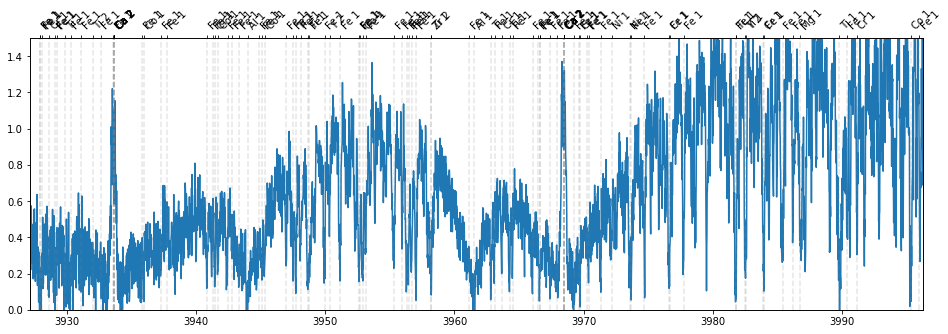

In [5]:
import sys, os
sys.path.insert(0, os.path.expanduser('~/git/cks_spots'))
from toolkit import EchelleSpectrum
import astropy.units as u
from astropy.io import fits

path = '/Users/bmmorris/data/cks/cks-k00003_bj122.81.fits'

hat11_spectrum = EchelleSpectrum.from_cks(path)
w = 3968*u.Angstrom

nearest_order = np.argmin(([abs(o.wavelength.mean() - w).value 
                            for o in hat11_spectrum.spectrum_list]))
order = hat11_spectrum.get_order(nearest_order)
rvshift = hat11_spectrum.rv_wavelength_shift(nearest_order, teff=4780)
hat11_spectrum.offset_wavelength_solution(rvshift)

fig, ax = plt.subplots(figsize=(16, 5))
order.plot(ax=ax)

line_kwargs = dict(color='gray', alpha=0.2, ls='--')
plot_lines(table, ax, 100, line_kwargs)

ax.set(ylim=[0, 1.5])#, xlim=[3930, 3940])
plt.show()
#ax.set(ylim=[0, 1.5], xlim=[3930, 3970])

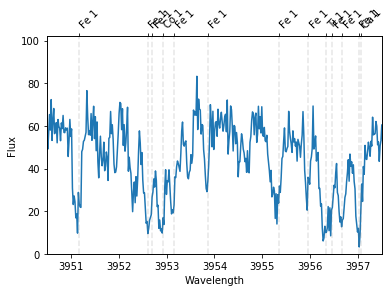

In [60]:
import ipywidgets as widgets
from IPython.html.widgets import interact

wavelength_width = widgets.IntSlider(min=0.1, max=order.wavelength.ptp().value, 
                                     step=0.1, value=order.wavelength.ptp().value,
                                     description="Wavelength Width:")

wavelength_center = widgets.IntSlider(min=order.wavelength.min().value, 
                                      max=order.wavelength.max().value, 
                                      step=0.1, value=order.wavelength.mean().value,
                                      description="Wavelength Center:")

flux_max = widgets.IntSlider(min=np.nanmin(order.flux).value, 
                             max=np.nanmax(order.flux).value, 
                             step=0.01, value=np.percentile(order.flux.value, 99.9), 
                             description='Flux Max:')

n_lines = widgets.IntSlider(min=0, max=len(table)//100, 
                            step=1, value=10, description="More/less lines:")

interact_kwargs = dict(wavelength_width=wavelength_width, 
                       wavelength_center=wavelength_center, 
                       flux_max=flux_max, n_lines=n_lines)

@interact(**interact_kwargs)
def plot(wavelength_width, wavelength_center, flux_max, n_lines):
    fig, ax = plt.subplots()
    ax.plot(order.wavelength, order.flux)
    
    line_kwargs = dict(color='gray', alpha=0.2, ls='--')

    ax.set(xlim=[wavelength_center - wavelength_width/2, wavelength_center + wavelength_width/2], ylim=[0, flux_max],
           xlabel='Wavelength', ylabel='Flux')
    plot_lines(table, ax, n_lines, line_kwargs)
    
    plt.show()